# baseline rf (bad)

## Dataset Creation

In [4]:
import pandas as pd
import numpy as np

# --- STEP 1: LOAD AND CLEAN COMBINED DATA ---
# Since open_journeys2 is a perfect subset, dat_train2 is our single master file.
df = pd.read_csv('dat_train2.csv')
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])

# Remove duplicates to ensure clean feature counts
# Updated to use 'id' instead of 'customer_id'
duplicate_mask = df.duplicated(subset=['id', 'event_name', 'event_timestamp'], keep='first')
df_clean = df[~duplicate_mask].copy()


# --- STEP 2: CREATE LABELS (SUCCESS VS. LAPSE) ---
# Identify Successful customers
# Expanded to include Fingerhut specific purchase events in addition to order_shipped
buy_events = ['order_shipped', 'place_order_web', 'place_order_phone']
success_ids = set(df_clean[df_clean['event_name'].isin(buy_events)]['id'])

# Identify Lapsed customers (No order + inactive for 60 days)
# max_date: The most recent timestamp in the entire dataset, used as "today"
# last_event: A dataframe containing only the very last chronological event for each journey 'id'
max_date = df_clean['event_timestamp'].max()
last_event = df_clean.sort_values('event_timestamp').groupby('id').tail(1)

def get_label(row):
    if row['id'] in success_ids:
        return 1 # Success
    if (max_date - row['event_timestamp']) >= pd.Timedelta(days=60):
        return 0 # Lapse
    return -1 # Active/Exclude

# labels: A dataframe containing the final binary target variable for valid training rows
last_event['label'] = last_event.apply(get_label, axis=1)
labels = last_event[last_event['label'] != -1][['id', 'label']]


# --- STEP 3: FLATTEN FEATURES FOR ALL USERS ---
df_clean['is_appl_submit'] = (df_clean['event_name'] == 'application_web_submit').astype(int)
df_clean['is_add_to_cart'] = (df_clean['event_name'] == 'add_to_cart').astype(int)
df_clean['is_browse'] = (df_clean['event_name'] == 'browse_products').astype(int)

# df_all_features: A dataframe containing flattened features for EVERY unique ID in the master file
df_all_features = df_clean.groupby('id').agg(
    total_actions=('event_name', 'count'),
    has_applied=('is_appl_submit', 'max'),
    max_items_in_cart=('is_add_to_cart', 'sum'),
    num_unique_products=('is_browse', 'sum')
).reset_index()


# --- STEP 4: SEPARATE TRAIN AND TEST SETS ---
# Merge features with labels to create the final df_train
# By merging here, any journey with a -1 label (active/incomplete) is automatically dropped from training
df_train = df_all_features.merge(labels, on='id')
df_train.to_csv('prepped_dat_train2.csv', index=False)
print("Training data prepped and saved.")

# Load the Kaggle template to know exactly which IDs need predictions
target_ids_df = pd.read_csv('open_journeys2_flattened_all0.csv')

# Filter the master feature dataframe to only include the exact Kaggle target IDs
df_test = df_all_features[df_all_features['id'].isin(target_ids_df['id'])].copy()

# Save the prepped open journeys data ready for modeling
df_test.to_csv('prepped_open_journeys2.csv', index=False)
print(f"Test data prepped and saved with {len(df_test)} rows.")

Training data prepped and saved.
Test data prepped and saved with 123467 rows.


## Modeling

Pearson Correlation with Target:
total_actions          0.229133
max_items_in_cart      0.227321
num_unique_products    0.180077
has_applied            0.013610
Name: label, dtype: float64 

Variance Inflation Factor (VIF):
               Feature        VIF
0        total_actions  14.945193
1          has_applied   1.915211
2    max_items_in_cart   3.900538
3  num_unique_products   9.148638 

Feature importance chart saved as 'feature_importance_chart.png'.

Final submission saved with 123467 rows.


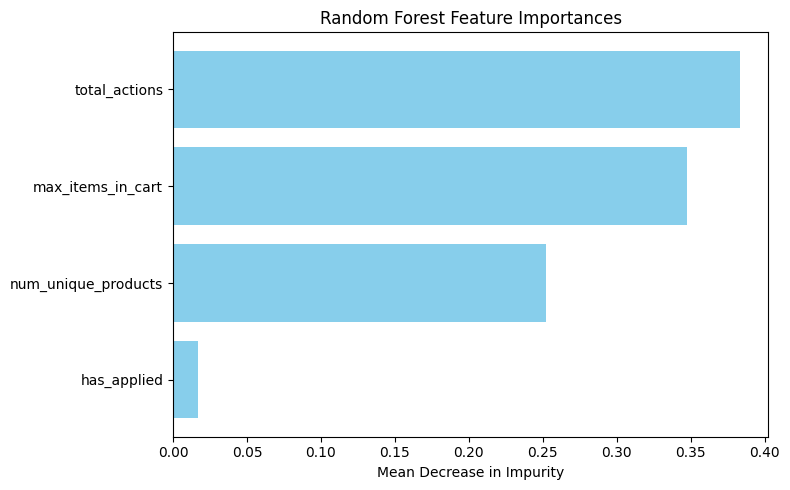

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- LOAD PREPPED DATA ---
df_train = pd.read_csv('prepped_dat_train2.csv')
df_test = pd.read_csv('prepped_open_journeys2.csv')

# --- STEP 5: MODEL DIAGNOSTICS AND TRAINING ---
feature_cols = ['total_actions', 'has_applied', 'max_items_in_cart', 'num_unique_products']
X_train = df_train[feature_cols]
y_train = df_train['label']
X_test = df_test[feature_cols]

# Calculate Pearson Correlation with target
print("Pearson Correlation with Target:")
correlations = df_train[feature_cols + ['label']].corr()['label'].drop('label')
print(correlations.sort_values(ascending=False), "\n")

# Calculate Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
print("Variance Inflation Factor (VIF):")
print(vif_data, "\n")

# Initialize and train the Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Generate and save Feature Importance chart
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Random Forest Feature Importances')
plt.xlabel('Mean Decrease in Impurity')
plt.tight_layout()
plt.savefig('feature_importance_chart.png')
print("Feature importance chart saved as 'feature_importance_chart.png'.\n")


# --- STEP 6: PREDICTION AND SUBMISSION FORMATTING ---
# Predict probabilities for the open journeys
probabilities = rf_model.predict_proba(X_test)[:, 1]

# Create the final submission dataframe
final_submission = pd.DataFrame({
    'id': df_test['id'],
    'order_shipped': probabilities
})

# Save the exact submission file ready for Kaggle
final_submission.to_csv('submission.csv', index=False)
print(f"Final submission saved with {len(final_submission)} rows.")

# xgboost + clustering test (.043)

## data set prep

/Users/aryan/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


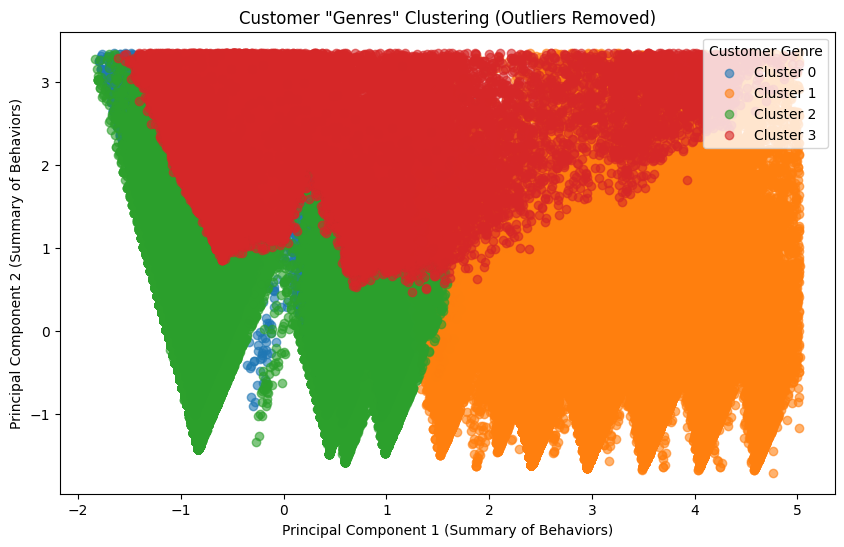

Average Stage Interactions per Cluster:
              Apply for Credit  Credit Account  Discover  Downpayment  \
temp_cluster                                                            
0                         4.65            0.05      1.02         0.01   
1                         5.39            1.01      0.58         2.26   
2                         5.44            0.05      0.00         0.01   
3                        19.37            0.31      0.74         0.31   

              First Purchase  Order Shipped  Unknown  cluster_0  cluster_1  \
temp_cluster                                                                 
0                      11.67           0.00     6.54        1.0        0.0   
1                      34.99           0.97     3.50        0.0        1.0   
2                      12.50           0.00     5.98        0.0        0.0   
3                     119.70           0.11    14.33        0.0        0.0   

              cluster_2  cluster_3  
temp_cluster   

In [9]:
import pandas as pd
import numpy as np
import io
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy import stats

# --- STEP 1: LOAD AND CLEAN COMBINED DATA ---
# Since open_journeys2 is a perfect subset, dat_train2 is our single master file.
df = pd.read_csv('dat_train2.csv')
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])

# Remove duplicates to ensure clean feature counts
# Updated to use 'id' instead of 'customer_id'
duplicate_mask = df.duplicated(subset=['id', 'event_name', 'event_timestamp'], keep='first')
df_clean = df[~duplicate_mask].copy()


# --- STEP 2: CREATE LABELS (SUCCESS VS. LAPSE) ---
# Identify Successful customers
# Expanded to include Fingerhut specific purchase events in addition to order_shipped
buy_events = ['order_shipped', 'place_order_web', 'place_order_phone']
success_ids = set(df_clean[df_clean['event_name'].isin(buy_events)]['id'])

# Identify Lapsed customers (No order + inactive for 60 days)
# max_date: The most recent timestamp in the entire dataset, used as "today"
# last_event: A dataframe containing only the very last chronological event for each journey 'id'
max_date = df_clean['event_timestamp'].max()
last_event = df_clean.sort_values('event_timestamp').groupby('id').tail(1).copy()

def get_label(row):
    if row['id'] in success_ids:
        return 1 # Success
    if (max_date - row['event_timestamp']) >= pd.Timedelta(days=60):
        return 0 # Lapse
    return -1 # Active/Exclude

# labels: A dataframe containing the final binary target variable for valid training rows
last_event['label'] = last_event.apply(get_label, axis=1)
labels = last_event[last_event['label'] != -1][['id', 'label']]


# --- CLUSTERING AND STAGE MAPPING ---
# 1. Load the provided key mapping into a DataFrame
key_csv_data = """event_name,journey_id,event_definition_id,milestone_number,stage
application_phone_approved,1,15,1,Apply for Credit
application_phone_declined,1,16,,Apply for Credit
application_phone_pending,1,17,,Apply for Credit
application_web_approved,1,12,1,Apply for Credit
application_web_declined,1,13,,Apply for Credit
application_web_pending,1,14,,Apply for Credit
application_web_submit,1,3,,Apply for Credit
application_web_view,1,19,,Apply for Credit
account_activitation,1,29,3,Credit Account
account_fraud_review,1,37,,Credit Account
campaign_click,1,2,,Discover
customer_requested_catalog_digital,1,9,,Discover
fingerhut_university,1,10,,Discover
pre_application_3rd_party_affiliates,1,22,,Discover
site_registration,1,23,,Discover
account_downpaymentcleared,1,27,5,Downpayment
account_downpaymentreceived,1,26,,Downpayment
place_downpayment,1,8,4,Downpayment
place_downpayment_phone,1,25,4,Downpayment
add_to_cart,1,11,,First Purchase
begin_checkout,1,6,,First Purchase
browse_products,1,4,,First Purchase
place_order_phone,1,18,2,First Purchase
place_order_web,1,7,2,First Purchase
view_cart,1,5,,First Purchase
order_shipped,1,28,6,Order Shipped
catalog_email_experian,1,20,,Prospecting
catalog_mail,1,21,,Prospecting"""

df_key = pd.read_csv(io.StringIO(key_csv_data))

# 2. Merge the stages onto your clean tracking data
# df_clean is the dataframe after removing duplicates in Task 2
df_merged = df_clean.merge(df_key[['event_name', 'stage']], on='event_name', how='left')
df_merged['stage'] = df_merged['stage'].fillna('Unknown') 

# 3. Create a feature matrix: count of interactions per stage for each customer
customer_profiles = pd.crosstab(df_merged['id'], df_merged['stage'])

# 4. Scale the features so stages with high volume do not dominate the distance metrics
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_profiles)

# 5. Apply K-Means Clustering (starting with 4 clusters as a guess)
# Increased n_init to 20 to experiment with more random starts for better grouping
kmeans = KMeans(n_clusters=4, random_state=42, n_init=20)
raw_clusters = kmeans.fit_predict(scaled_features)

# Convert clusters into one-hot encoded dummy variables to avoid ordinal bias
cluster_dummies = pd.get_dummies(raw_clusters, prefix='cluster', dtype=int)
customer_profiles = pd.concat([customer_profiles.reset_index(), cluster_dummies], axis=1)

# 6. Reduce dimensions to 2D using PCA for visualization purposes
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# 7. Identify outliers using Z-scores on the PCA features
# Calculate the Z-score for each principal component
z_scores = np.abs(stats.zscore(pca_features))

# Define a threshold (e.g., 3 standard deviations from the mean)
threshold = 3

# Create a boolean mask to keep only the rows where both PCA components are within the threshold
# This filters out extreme outliers that stretch the plot
mask = (z_scores[:, 0] < threshold) & (z_scores[:, 1] < threshold)

# Apply the mask to our features and cluster labels
clean_pca_features = pca_features[mask]
clean_clusters = raw_clusters[mask]

# 8. Plot the cleaned clusters with a discrete legend
plt.figure(figsize=(10, 6))
unique_clusters = np.unique(clean_clusters)

for cluster_id in unique_clusters:
    idx = clean_clusters == cluster_id
    plt.scatter(clean_pca_features[idx, 0], clean_pca_features[idx, 1], label=f'Cluster {cluster_id}', alpha=0.6)

plt.title('Customer "Genres" Clustering (Outliers Removed)')
plt.xlabel('Principal Component 1 (Summary of Behaviors)')
plt.ylabel('Principal Component 2 (Summary of Behaviors)')
plt.legend(title='Customer Genre')
plt.show() # Replaced savefig with show

# 9. Output the average stage interactions per cluster to interpret the "genres"
# Re-attach the raw cluster ID just for this summary calculation
temp_profiles = pd.concat([customer_profiles, pd.Series(raw_clusters, name='temp_cluster')], axis=1)
cluster_summary = temp_profiles.groupby('temp_cluster').mean(numeric_only=True)
print("Average Stage Interactions per Cluster:")
print(cluster_summary.round(2))

# Drop the temporary cluster ID so it doesn't leak into the final dataset
# customer_profiles is already reset_index()


# --- STEP 3: FLATTEN FEATURES FOR ALL USERS ---
df_clean['is_appl_submit'] = (df_clean['event_name'] == 'application_web_submit').astype(int)
df_clean['is_add_to_cart'] = (df_clean['event_name'] == 'add_to_cart').astype(int)
df_clean['is_browse'] = (df_clean['event_name'] == 'browse_products').astype(int)

# df_all_features: A dataframe containing flattened features for EVERY unique ID in the master file
df_basic_features = df_clean.groupby('id').agg(
    total_actions=('event_name', 'count'),
    has_applied=('is_appl_submit', 'max'),
    max_items_in_cart=('is_add_to_cart', 'sum'),
    num_unique_products=('is_browse', 'sum')
).reset_index()

df_all_features = df_basic_features.merge(customer_profiles, on='id', how='left')


# --- STEP 4: SEPARATE TRAIN AND TEST SETS ---
# Merge features with labels to create the final df_train
# By merging here, any journey with a -1 label (active/incomplete) is automatically dropped from training
df_train = df_all_features.merge(labels, on='id')
df_train.to_csv('prepped_dat_train2.csv', index=False)
print("Training data prepped and saved.")

# Load the Kaggle template to know exactly which IDs need predictions
target_ids_df = pd.read_csv('open_journeys2_flattened_all0.csv')

# Filter the master feature dataframe to only include the exact Kaggle target IDs
df_test = df_all_features[df_all_features['id'].isin(target_ids_df['id'])].copy()

# Save the prepped open journeys data ready for modeling
df_test.to_csv('prepped_open_journeys2.csv', index=False)
print(f"Test data prepped and saved with {len(df_test)} rows.")

## modeling

Training with 2 features.
Pearson Correlation with Target:
cluster_1   -0.290303
cluster_0   -0.363239
Name: label, dtype: float64 

Variance Inflation Factor (VIF):
     Feature  VIF
0  cluster_0  1.0
1  cluster_1  1.0 



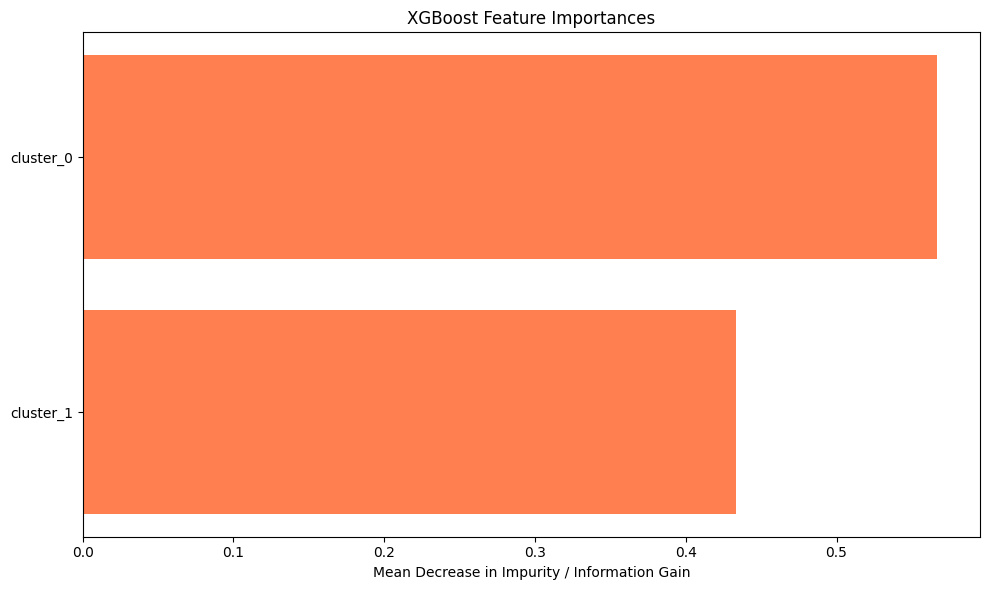

Final submission saved with 123467 rows.


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- LOAD PREPPED DATA ---
df_train = pd.read_csv('prepped_dat_train2.csv')
df_test = pd.read_csv('prepped_open_journeys2.csv')

# --- CONFIGURE FEATURES ---
# Easily add or comment out features in this list to experiment with your model
features_to_use = [
    #'total_actions', 
    #'has_applied', 
    #'max_items_in_cart', 
    #'num_unique_products', 
    'cluster_0',
    'cluster_1',
    #'cluster_2',
    #'cluster_3',
    #'Apply for Credit',
    #'Credit Account',
    #'Discover',
    #'Downpayment',
    #'First Purchase',
    #'Prospecting',
    #'Unknown'
]



# Ensure we only attempt to use features that actually exist in the dataframe
feature_cols = [col for col in features_to_use if col in df_train.columns]
print(f"Training with {len(feature_cols)} features.")

# --- STEP 5: MODEL DIAGNOSTICS AND TRAINING ---
X_train = df_train[feature_cols]
y_train = df_train['label']
X_test = df_test[feature_cols]

# Calculate Pearson Correlation with target
print("Pearson Correlation with Target:")
correlations = df_train[feature_cols + ['label']].corr()['label'].drop('label')
print(correlations.sort_values(ascending=False), "\n")

# Calculate Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
print("Variance Inflation Factor (VIF):")
print(vif_data, "\n")

# Initialize and train the XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

# Generate and show Feature Importance chart
importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='coral')
plt.title('XGBoost Feature Importances')
plt.xlabel('Mean Decrease in Impurity / Information Gain')
plt.tight_layout()
plt.show() # Replaced savefig with show


# --- STEP 6: PREDICTION AND SUBMISSION FORMATTING ---
# Predict probabilities for the open journeys
probabilities = xgb_model.predict_proba(X_test)[:, 1]

# Create the final submission dataframe
final_submission = pd.DataFrame({
    'id': df_test['id'],
    'order_shipped': probabilities
})

# Save the exact submission file ready for Kaggle
final_submission.to_csv('submission.csv', index=False)
print(f"Final submission saved with {len(final_submission)} rows.")

# clustering only (.044 max)

## data prep

/Users/aryan/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


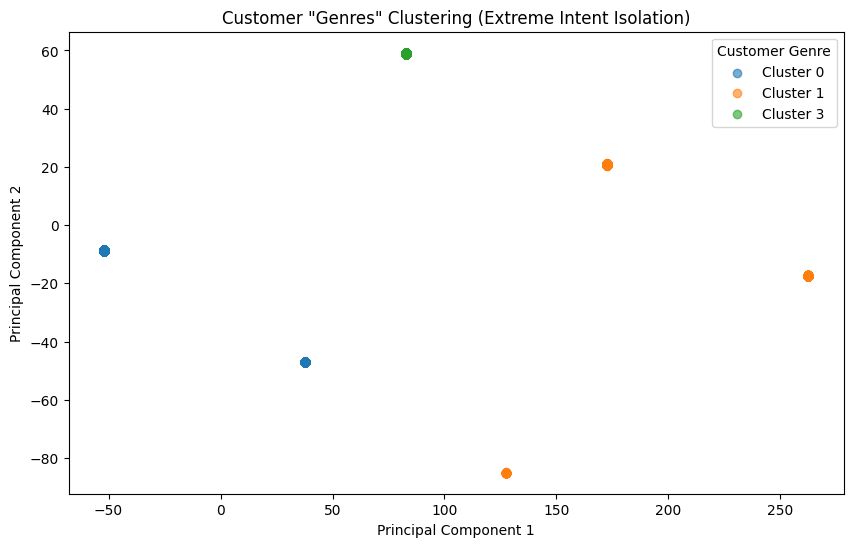

Average Stage Interactions per Cluster:
              Apply for Credit  Credit Account  Discover  Downpayment  \
temp_cluster                                                            
0                         5.50            0.00      0.61         0.00   
1                         5.90            1.00      0.60         2.18   
2                         6.32            1.03      0.61         5.00   
3                         6.80            1.01      0.58         0.38   

              First Purchase  Unknown  
temp_cluster                           
0                      14.94     6.85  
1                      40.70     3.72  
2                      49.59     3.96  
3                      35.38     4.14  
Training data prepped and saved.
Test data prepped and saved with 123467 rows.


In [23]:
import pandas as pd
import numpy as np
import io
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy import stats

# --- STEP 1: LOAD AND CLEAN COMBINED DATA ---
# Since open_journeys2 is a perfect subset, dat_train2 is our single master file.
df = pd.read_csv('dat_train2.csv')
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])

# Remove duplicates to ensure clean feature counts
# Updated to use 'id' instead of 'customer_id'
duplicate_mask = df.duplicated(subset=['id', 'event_name', 'event_timestamp'], keep='first')
df_clean = df[~duplicate_mask].copy()


# --- STEP 2: CREATE LABELS (SUCCESS VS. LAPSE) ---
# Identify Successful customers
# Expanded to include Fingerhut specific purchase events in addition to order_shipped
buy_events = ['order_shipped', 'place_order_web', 'place_order_phone']
success_ids = set(df_clean[df_clean['event_name'].isin(buy_events)]['id'])

# Identify Lapsed customers (No order + inactive for 60 days)
# max_date: The most recent timestamp in the entire dataset, used as "today"
# last_event: A dataframe containing only the very last chronological event for each journey 'id'
max_date = df_clean['event_timestamp'].max()
last_event = df_clean.sort_values('event_timestamp').groupby('id').tail(1).copy()

def get_label(row):
    if row['id'] in success_ids:
        return 1 # Success
    if (max_date - row['event_timestamp']) >= pd.Timedelta(days=60):
        return 0 # Lapse
    return -1 # Active/Exclude

# labels: A dataframe containing the final binary target variable for valid training rows
last_event['label'] = last_event.apply(get_label, axis=1)
labels = last_event[last_event['label'] != -1][['id', 'label']]


# --- CLUSTERING AND STAGE MAPPING ---
# 1. Load the provided key mapping into a DataFrame
key_csv_data = """event_name,journey_id,event_definition_id,milestone_number,stage
application_phone_approved,1,15,1,Apply for Credit
application_phone_declined,1,16,,Apply for Credit
application_phone_pending,1,17,,Apply for Credit
application_web_approved,1,12,1,Apply for Credit
application_web_declined,1,13,,Apply for Credit
application_web_pending,1,14,,Apply for Credit
application_web_submit,1,3,,Apply for Credit
application_web_view,1,19,,Apply for Credit
account_activitation,1,29,3,Credit Account
account_fraud_review,1,37,,Credit Account
campaign_click,1,2,,Discover
customer_requested_catalog_digital,1,9,,Discover
fingerhut_university,1,10,,Discover
pre_application_3rd_party_affiliates,1,22,,Discover
site_registration,1,23,,Discover
account_downpaymentcleared,1,27,5,Downpayment
account_downpaymentreceived,1,26,,Downpayment
place_downpayment,1,8,4,Downpayment
place_downpayment_phone,1,25,4,Downpayment
add_to_cart,1,11,,First Purchase
begin_checkout,1,6,,First Purchase
browse_products,1,4,,First Purchase
place_order_phone,1,18,2,First Purchase
place_order_web,1,7,2,First Purchase
view_cart,1,5,,First Purchase
order_shipped,1,28,6,Order Shipped
catalog_email_experian,1,20,,Prospecting
catalog_mail,1,21,,Prospecting"""

df_key = pd.read_csv(io.StringIO(key_csv_data))

# 2. Merge the stages onto your clean tracking data
# df_clean is the dataframe after removing duplicates in Task 2
df_merged = df_clean.merge(df_key[['event_name', 'stage']], on='event_name', how='left')
df_merged['stage'] = df_merged['stage'].fillna('Unknown') 

# 3. Create a feature matrix: count of interactions per stage for each customer
customer_profiles = pd.crosstab(df_merged['id'], df_merged['stage'])

# Remove ONLY the actual target leak (Order Shipped), keep the golden signals
if 'Order Shipped' in customer_profiles.columns:
    customer_profiles = customer_profiles.drop(columns=['Order Shipped'])

# 4. Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_profiles)

# EXTREME WEIGHTING: Force K-Means to isolate sure-fire behaviors
feature_cols_for_scaling = customer_profiles.columns.tolist()
if 'Downpayment' in feature_cols_for_scaling:
    idx = feature_cols_for_scaling.index('Downpayment')
    scaled_features[:, idx] *= 100.0  # Massive weight

if 'Credit Account' in feature_cols_for_scaling:
    idx = feature_cols_for_scaling.index('Credit Account')
    scaled_features[:, idx] *= 50.0  # Heavy weight

# 5. Apply K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=20)
raw_clusters = kmeans.fit_predict(scaled_features)

# Convert clusters into one-hot encoded dummy variables to avoid ordinal bias
cluster_dummies = pd.get_dummies(raw_clusters, prefix='cluster', dtype=int)
customer_profiles = pd.concat([customer_profiles.reset_index(), cluster_dummies], axis=1)

# 6. Reduce dimensions to 2D using PCA for visualization purposes
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# 7. Identify outliers using Z-scores on the PCA features
z_scores = np.abs(stats.zscore(pca_features))
threshold = 3
mask = (z_scores[:, 0] < threshold) & (z_scores[:, 1] < threshold)

clean_pca_features = pca_features[mask]
clean_clusters = raw_clusters[mask]

# 8. Plot the cleaned clusters with a discrete legend
plt.figure(figsize=(10, 6))
unique_clusters = np.unique(clean_clusters)

for cluster_id in unique_clusters:
    idx = clean_clusters == cluster_id
    plt.scatter(clean_pca_features[idx, 0], clean_pca_features[idx, 1], label=f'Cluster {cluster_id}', alpha=0.6)

plt.title('Customer "Genres" Clustering (Extreme Intent Isolation)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Customer Genre')
plt.show() 

# 9. Output the average stage interactions per cluster to interpret the "genres"
# Re-attach raw clusters to the unscaled features to see what the model found
temp_profiles = pd.concat([customer_profiles.drop(columns=[col for col in customer_profiles.columns if col.startswith('cluster_')]), pd.Series(raw_clusters, name='temp_cluster')], axis=1)
cluster_summary = temp_profiles.groupby('temp_cluster').mean(numeric_only=True)
print("Average Stage Interactions per Cluster:")
print(cluster_summary.round(2))

# --- STEP 3: FLATTEN FEATURES FOR ALL USERS ---
df_clean['is_appl_submit'] = (df_clean['event_name'] == 'application_web_submit').astype(int)
df_clean['is_add_to_cart'] = (df_clean['event_name'] == 'add_to_cart').astype(int)
df_clean['is_browse'] = (df_clean['event_name'] == 'browse_products').astype(int)

# df_all_features: A dataframe containing flattened features for EVERY unique ID in the master file
df_basic_features = df_clean.groupby('id').agg(
    total_actions=('event_name', 'count'),
    has_applied=('is_appl_submit', 'max'),
    max_items_in_cart=('is_add_to_cart', 'sum'),
    num_unique_products=('is_browse', 'sum')
).reset_index()

df_all_features = df_basic_features.merge(customer_profiles, on='id', how='left')


# --- STEP 4: SEPARATE TRAIN AND TEST SETS ---
# Merge features with labels to create the final df_train
df_train = df_all_features.merge(labels, on='id')
df_train.to_csv('prepped_dat_train2.csv', index=False)
print("Training data prepped and saved.")

# Load the Kaggle template to know exactly which IDs need predictions
target_ids_df = pd.read_csv('open_journeys2_flattened_all0.csv')

# Filter the master feature dataframe to only include the exact Kaggle target IDs
df_test = df_all_features[df_all_features['id'].isin(target_ids_df['id'])].copy()

# Save the prepped open journeys data ready for modeling
df_test.to_csv('prepped_open_journeys2.csv', index=False)
print(f"Test data prepped and saved with {len(df_test)} rows.")

## modeling

Historical Success Rates by Cluster:
cluster_0: 0.0240 success rate
cluster_1: 0.9997 success rate
cluster_2: 0.9998 success rate
cluster_3: 0.5936 success rate

Identifying 'cluster_2' as the Surefire Completed cluster.


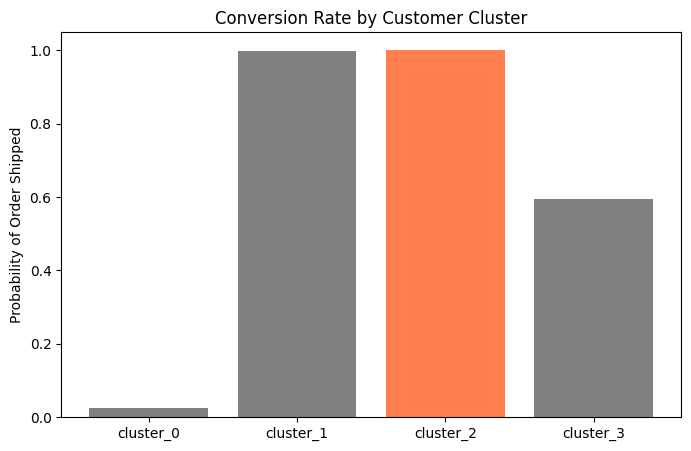

Final binary submission saved with 123467 rows.
Assigned 0.95 probability to 1159 high-intent journeys.
Assigned 0.00 probability to 122308 standard journeys.


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- LOAD PREPPED DATA ---
df_train = pd.read_csv('prepped_dat_train2.csv')
df_test = pd.read_csv('prepped_open_journeys2.csv')

# --- STEP 5: IDENTIFY THE SUREFIRE CLUSTER ---
cluster_cols = [col for col in df_train.columns if col.startswith('cluster_')]

print("Historical Success Rates by Cluster:")
best_cluster = None
highest_rate = -1

for col in cluster_cols:
    # Calculate the mean success rate (target label) for users in this cluster
    success_rate = df_train[df_train[col] == 1]['label'].mean()
    print(f"{col}: {success_rate:.4f} success rate")
    
    if success_rate > highest_rate:
        highest_rate = success_rate
        best_cluster = col

print(f"\nIdentifying '{best_cluster}' as the Surefire Completed cluster.")

# Visualize the stark difference in success rates
rates = [df_train[df_train[col] == 1]['label'].mean() for col in cluster_cols]
plt.figure(figsize=(8, 5))
plt.bar(cluster_cols, rates, color=['coral' if col == best_cluster else 'gray' for col in cluster_cols])
plt.title('Conversion Rate by Customer Cluster')
plt.ylabel('Probability of Order Shipped')
plt.show() 


# --- STEP 6: BINARY PREDICTION AND SUBMISSION ---
# Initialize ALL predictions to exactly 0 to match your baseline strategy
probabilities = np.zeros(len(df_test))

# Create a mask identifying which rows in the test set belong to the surefire cluster
surefire_mask = df_test[best_cluster] == 1
surefire_mask = df_test["cluster_1"] == 1


# Only override the 0s for the absolute surefire cluster
# Using 0.95 instead of 1.0 is a safety net; if a single user in this group fails, 
# a prediction of 1.0 yields an infinite log loss penalty. 0.95 protects against that.
probabilities[surefire_mask] = 1 

# Create the final submission dataframe
final_submission = pd.DataFrame({
    'id': df_test['id'],
    'order_shipped': probabilities
})

# Save the exact submission file ready for Kaggle
final_submission.to_csv('binary_heuristic_submission.csv', index=False)
print(f"Final binary submission saved with {len(final_submission)} rows.")
print(f"Assigned 0.95 probability to {surefire_mask.sum()} high-intent journeys.")
print(f"Assigned 0.00 probability to {len(df_test) - surefire_mask.sum()} standard journeys.")

# xgboost + clusterting attempt 2

## data prep

/Users/aryan/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


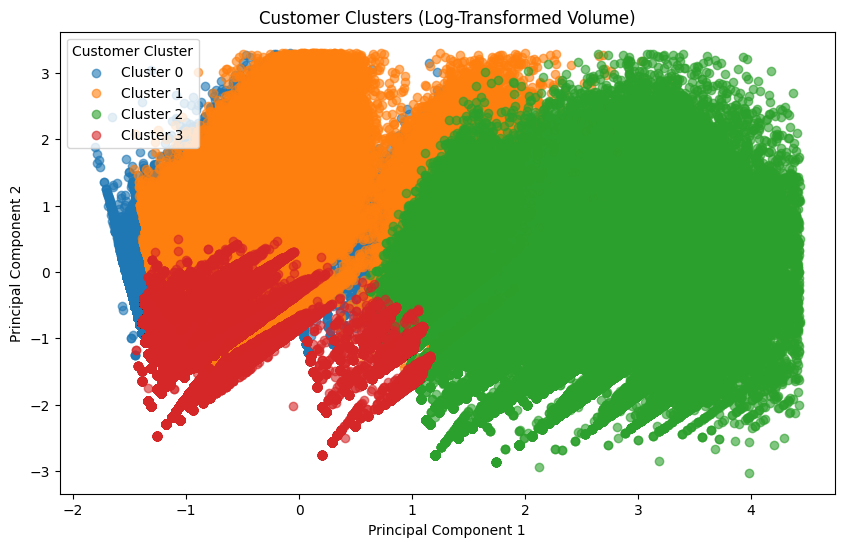

Average Stage Interactions per Cluster:
              Apply for Credit  Credit Account  Discover  Downpayment  \
temp_cluster                                                            
0                         1.24            0.01      0.68         0.00   
1                        12.98            0.05      0.57         0.00   
2                         5.60            1.01      0.59         2.03   
3                         3.74            0.02      0.57         0.00   

              First Purchase  Unknown  
temp_cluster                           
0                      15.88    10.66  
1                      26.52     7.88  
2                      40.03     3.68  
3                       3.43     0.68  
Training data prepped and saved.
Test data prepped and saved with 123467 rows.


In [33]:
import pandas as pd
import numpy as np
import io
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy import stats

# --- STEP 1: LOAD AND CLEAN COMBINED DATA ---
# Since open_journeys2 is a perfect subset, dat_train2 is our single master file.
df = pd.read_csv('dat_train2.csv')
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])

# Remove duplicates to ensure clean feature counts
# Updated to use 'id' instead of 'customer_id'
duplicate_mask = df.duplicated(subset=['id', 'event_name', 'event_timestamp'], keep='first')
df_clean = df[~duplicate_mask].copy()


# --- STEP 2: CREATE LABELS (SUCCESS VS. LAPSE) ---
# Identify Successful customers
# Expanded to include Fingerhut specific purchase events in addition to order_shipped
buy_events = ['order_shipped', 'place_order_web', 'place_order_phone']
success_ids = set(df_clean[df_clean['event_name'].isin(buy_events)]['id'])

# Identify Lapsed customers (No order + inactive for 60 days)
# max_date: The most recent timestamp in the entire dataset, used as "today"
# last_event: A dataframe containing only the very last chronological event for each journey 'id'
max_date = df_clean['event_timestamp'].max()
last_event = df_clean.sort_values('event_timestamp').groupby('id').tail(1).copy()

def get_label(row):
    if row['id'] in success_ids:
        return 1 # Success
    if (max_date - row['event_timestamp']) >= pd.Timedelta(days=60):
        return 0 # Lapse
    return -1 # Active/Exclude

# labels: A dataframe containing the final binary target variable for valid training rows
last_event['label'] = last_event.apply(get_label, axis=1)
labels = last_event[last_event['label'] != -1][['id', 'label']]


# --- CLUSTERING AND STAGE MAPPING ---
# 1. Load the provided key mapping into a DataFrame
key_csv_data = """event_name,journey_id,event_definition_id,milestone_number,stage
application_phone_approved,1,15,1,Apply for Credit
application_phone_declined,1,16,,Apply for Credit
application_phone_pending,1,17,,Apply for Credit
application_web_approved,1,12,1,Apply for Credit
application_web_declined,1,13,,Apply for Credit
application_web_pending,1,14,,Apply for Credit
application_web_submit,1,3,,Apply for Credit
application_web_view,1,19,,Apply for Credit
account_activitation,1,29,3,Credit Account
account_fraud_review,1,37,,Credit Account
campaign_click,1,2,,Discover
customer_requested_catalog_digital,1,9,,Discover
fingerhut_university,1,10,,Discover
pre_application_3rd_party_affiliates,1,22,,Discover
site_registration,1,23,,Discover
account_downpaymentcleared,1,27,5,Downpayment
account_downpaymentreceived,1,26,,Downpayment
place_downpayment,1,8,4,Downpayment
place_downpayment_phone,1,25,4,Downpayment
add_to_cart,1,11,,First Purchase
begin_checkout,1,6,,First Purchase
browse_products,1,4,,First Purchase
place_order_phone,1,18,2,First Purchase
place_order_web,1,7,2,First Purchase
view_cart,1,5,,First Purchase
order_shipped,1,28,6,Order Shipped
catalog_email_experian,1,20,,Prospecting
catalog_mail,1,21,,Prospecting"""

df_key = pd.read_csv(io.StringIO(key_csv_data))

# 2. Merge the stages onto your clean tracking data
# df_clean is the dataframe after removing duplicates in Task 2
df_merged = df_clean.merge(df_key[['event_name', 'stage']], on='event_name', how='left')
df_merged['stage'] = df_merged['stage'].fillna('Unknown') 

# 3. Create a feature matrix: count of interactions per stage for each customer
customer_profiles = pd.crosstab(df_merged['id'], df_merged['stage'])

# Remove the actual target leak (Order Shipped) so we do not cluster based on the answer
if 'Order Shipped' in customer_profiles.columns:
    customer_profiles = customer_profiles.drop(columns=['Order Shipped'])

# NEW: Apply log transformation ln(x+1) to tame volume outliers but preserve magnitude
customer_log_profiles = np.log1p(customer_profiles)

# 4. Scale the log-transformed features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_log_profiles)

# 5. Apply K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=20)
raw_clusters = kmeans.fit_predict(scaled_features)

# Convert clusters into one-hot encoded dummy variables to avoid ordinal bias
cluster_dummies = pd.get_dummies(raw_clusters, prefix='cluster', dtype=int)
customer_profiles = pd.concat([customer_profiles.reset_index(), cluster_dummies], axis=1)

# 6. Reduce dimensions to 2D using PCA for visualization purposes
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# 7. Identify outliers using Z-scores on the PCA features
z_scores = np.abs(stats.zscore(pca_features))
threshold = 3
mask = (z_scores[:, 0] < threshold) & (z_scores[:, 1] < threshold)

clean_pca_features = pca_features[mask]
clean_clusters = raw_clusters[mask]

# 8. Plot the cleaned clusters with a discrete legend
plt.figure(figsize=(10, 6))
unique_clusters = np.unique(clean_clusters)

for cluster_id in unique_clusters:
    idx = clean_clusters == cluster_id
    plt.scatter(clean_pca_features[idx, 0], clean_pca_features[idx, 1], label=f'Cluster {cluster_id}', alpha=0.6)

plt.title('Customer Clusters (Log-Transformed Volume)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Customer Cluster')
plt.show() 

# 9. Output the average stage interactions per cluster to interpret the "genres"
temp_profiles = pd.concat([customer_profiles.drop(columns=[col for col in customer_profiles.columns if col.startswith('cluster_')]).drop(columns='id', errors='ignore'), pd.Series(raw_clusters, name='temp_cluster')], axis=1)
cluster_summary = temp_profiles.groupby('temp_cluster').mean(numeric_only=True)
print("Average Stage Interactions per Cluster:")
print(cluster_summary.round(2))

# --- STEP 3: FLATTEN FEATURES FOR ALL USERS ---
df_clean['is_appl_submit'] = (df_clean['event_name'] == 'application_web_submit').astype(int)
df_clean['is_add_to_cart'] = (df_clean['event_name'] == 'add_to_cart').astype(int)
df_clean['is_browse'] = (df_clean['event_name'] == 'browse_products').astype(int)

# df_all_features: A dataframe containing flattened features for EVERY unique ID in the master file
df_basic_features = df_clean.groupby('id').agg(
    total_actions=('event_name', 'count'),
    has_applied=('is_appl_submit', 'max'),
    max_items_in_cart=('is_add_to_cart', 'sum'),
    num_unique_products=('is_browse', 'sum')
).reset_index()

df_all_features = df_basic_features.merge(customer_profiles, on='id', how='left')


# --- STEP 4: SEPARATE TRAIN AND TEST SETS ---
# Merge features with labels to create the final df_train
df_train = df_all_features.merge(labels, on='id')
df_train.to_csv('prepped_dat_train2.csv', index=False)
print("Training data prepped and saved.")

# Load the Kaggle template to know exactly which IDs need predictions
target_ids_df = pd.read_csv('open_journeys2_flattened_all0.csv')

# Filter the master feature dataframe to only include the exact Kaggle target IDs
df_test = df_all_features[df_all_features['id'].isin(target_ids_df['id'])].copy()

# Save the prepped open journeys data ready for modeling
df_test.to_csv('prepped_open_journeys2.csv', index=False)
print(f"Test data prepped and saved with {len(df_test)} rows.")

## modeling

Configured to start XGBoost with 14 features.

Calculated scale_pos_weight: 2.95
This means false negatives are penalized much heavier than false positives.

Running Pass 1: Analyzing feature importances...

Importance Filter Active (Threshold = 0.1):
  - Dropping 'total_actions' (Importance: 0.0033)
  - Dropping 'has_applied' (Importance: 0.0130)
  - Dropping 'max_items_in_cart' (Importance: 0.0010)
  - Dropping 'num_unique_products' (Importance: 0.0497)
  - Dropping 'cluster_0' (Importance: 0.0034)
  - Dropping 'cluster_1' (Importance: 0.0047)
  - Dropping 'cluster_3' (Importance: 0.0033)
  - Dropping 'Apply for Credit' (Importance: 0.0020)
  - Dropping 'Discover' (Importance: 0.0081)
  - Dropping 'First Purchase' (Importance: 0.0085)
  - Dropping 'Unknown' (Importance: 0.0060)
Proceeding to Pass 2 with 3 remaining features.

Running Pass 2: Training final model on optimized feature set...

--- FINAL NUMERICAL FEATURE IMPORTANCES ---
       Feature  Importance
Credit Account    0.447

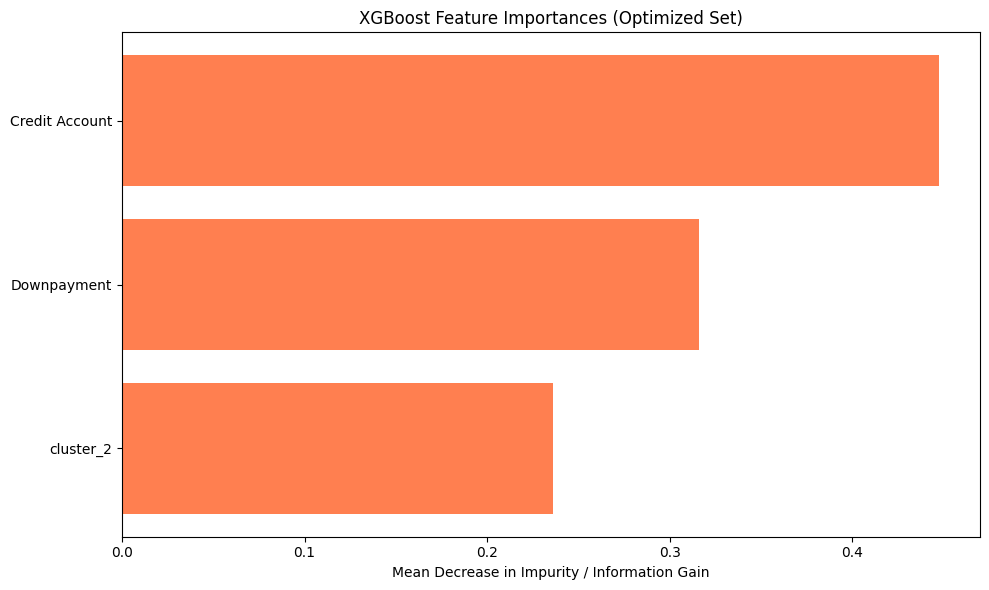

Final submission saved with 123467 rows.


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
from scipy import stats

# --- LOAD PREPPED DATA ---
df_train = pd.read_csv('prepped_dat_train2.csv')
df_test = pd.read_csv('prepped_open_journeys2.csv')

# --- CONFIGURE FEATURES AND FILTERS ---
# Easily add or comment out features in this list to experiment with your model
# You can remove specific stages if you think they are adding noise
features_to_use = [
    'total_actions', 
    'has_applied', 
    'max_items_in_cart', 
    'num_unique_products', 
    'cluster_0',
    'cluster_1',
    'cluster_2',
    'cluster_3',
    'Apply for Credit',
    'Credit Account',
    'Discover',
    'Downpayment',
    'First Purchase',
    'Prospecting',
    'Unknown'
]

# Toggle to filter out extreme edge cases in the training data (e.g., bots)
FILTER_OUTLIERS = False
# Z-score threshold (3.0 means keep 99.7% of data, drop the extreme 0.3%)
OUTLIER_THRESHOLD_Z = 3.0 
# Which feature to check for extreme edge cases
OUTLIER_FEATURE = 'total_actions' 

# NEW: Toggle to automatically drop low importance features
AUTO_DROP_LOW_IMPORTANCE = True
# Features with an importance score below this decimal will be excluded in Pass 2
IMPORTANCE_THRESHOLD = 0.1

# Ensure we only attempt to use features that actually exist in the dataframe
feature_cols = [col for col in features_to_use if col in df_train.columns]
print(f"Configured to start XGBoost with {len(feature_cols)} features.\n")

# --- STEP 4.5: APPLY OUTLIER FILTERING ---
if FILTER_OUTLIERS and OUTLIER_FEATURE in df_train.columns:
    initial_rows = len(df_train)
    # Calculate the Z-scores for the chosen feature
    z_scores = np.abs(stats.zscore(df_train[OUTLIER_FEATURE]))
    # Keep only rows where the Z-score is less than our threshold
    df_train = df_train[z_scores < OUTLIER_THRESHOLD_Z].copy()
    dropped_rows = initial_rows - len(df_train)
    print(f"Outlier Filter Active: Dropped {dropped_rows} extreme edge cases based on {OUTLIER_FEATURE}.\n")

# --- STEP 5: PASS 1 - INITIAL MODEL DIAGNOSTICS AND TRAINING ---
X_train = df_train[feature_cols]
y_train = df_train['label']
X_test = df_test[feature_cols]

# Dynamically calculate the scale_pos_weight based on the training data imbalance
# W = N_neg / N_pos
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
imbalance_weight = n_neg / n_pos
print(f"Calculated scale_pos_weight: {imbalance_weight:.2f}")
print("This means false negatives are penalized much heavier than false positives.\n")

# Initialize the XGBoost model parameters for both passes
# Learning rate is kept low (0.05) to ensure stable probability outputs
# Added gamma, min_child_weight, and scale_pos_weight to handle the imbalance
xgb_params = {
    'n_estimators': 200,             # Slightly more trees since learning rate is low
    'learning_rate': 0.03,           # Lower learning rate for smoother probability curves
    'max_depth': 4,                  # Keep trees shallow to prevent overfitting on noise
    'subsample': 0.8,                # Randomly sample 80% of rows per tree
    'colsample_bytree': 0.8,         # Randomly sample 80% of columns per tree
    'gamma': 2.0,                    # Minimum loss reduction required to make a split
    'min_child_weight': 5,           # Minimum number of instances required in a leaf node
    'scale_pos_weight': imbalance_weight, # Force model to care about the minority class
    'random_state': 42,
    'eval_metric': 'logloss'
}

# Pass 1: Train to find feature importances
print("Running Pass 1: Analyzing feature importances...")
xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(X_train, y_train)

# --- STEP 5.5: PASS 2 - AUTOMATIC FEATURE FILTERING ---
if AUTO_DROP_LOW_IMPORTANCE:
    importances = xgb_model.feature_importances_
    
    # Identify which features meet the threshold
    kept_features = []
    dropped_features = []
    for col, imp in zip(feature_cols, importances):
        if imp >= IMPORTANCE_THRESHOLD:
            kept_features.append(col)
        else:
            dropped_features.append((col, imp))
            
    print(f"\nImportance Filter Active (Threshold = {IMPORTANCE_THRESHOLD}):")
    for col, imp in dropped_features:
        print(f"  - Dropping '{col}' (Importance: {imp:.4f})")
        
    print(f"Proceeding to Pass 2 with {len(kept_features)} remaining features.\n")
    
    # Re-assign training and test sets with strictly the kept features
    feature_cols = kept_features
    X_train = df_train[feature_cols]
    X_test = df_test[feature_cols]
    
    # Pass 2: Re-train the model strictly on the surviving features
    print("Running Pass 2: Training final model on optimized feature set...")
    xgb_model = xgb.XGBClassifier(**xgb_params)
    xgb_model.fit(X_train, y_train)

# Generate and show Feature Importance chart for the final model
final_importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': final_importances})
# Sort descending for printing, ascending for the bar chart
importance_df_print = importance_df.sort_values(by='Importance', ascending=False)
importance_df_plot = importance_df.sort_values(by='Importance', ascending=True)

print("\n--- FINAL NUMERICAL FEATURE IMPORTANCES ---")
print(importance_df_print.to_string(index=False))
print("\n")

plt.figure(figsize=(10, 6))
plt.barh(importance_df_plot['Feature'], importance_df_plot['Importance'], color='coral')
plt.title('XGBoost Feature Importances (Optimized Set)')
plt.xlabel('Mean Decrease in Impurity / Information Gain')
plt.tight_layout()
plt.show() 

# --- STEP 6: PREDICTION AND SUBMISSION FORMATTING ---
# Predict probabilities for the open journeys
# predict_proba returns a 2D array [prob_class_0, prob_class_1], we want index 1
probabilities = xgb_model.predict_proba(X_test)[:, 1]

# Create the final submission dataframe
final_submission = pd.DataFrame({
    'id': df_test['id'],
    'order_shipped': probabilities
})

# Save the exact submission file ready for Kaggle
final_submission.to_csv('xgb_submission.csv', index=False)
print(f"Final submission saved with {len(final_submission)} rows.")

# clustering iteration

In [ ]:
import pandas as pd
import numpy as np
import io
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# --- STEP 1: LOAD AND CLEAN COMBINED DATA ---
# Since open_journeys2 is a perfect subset, dat_train2 is our single master file.
df = pd.read_csv('dat_train2.csv')
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])

# Remove duplicates to ensure clean feature counts
# Updated to use 'id' instead of 'customer_id'
duplicate_mask = df.duplicated(subset=['id', 'event_name', 'event_timestamp'], keep='first')
df_clean = df[~duplicate_mask].copy()


# --- STEP 2: CREATE LABELS (SUCCESS VS. LAPSE) ---
# Identify Successful customers
# Expanded to include Fingerhut specific purchase events in addition to order_shipped
buy_events = ['order_shipped', 'place_order_web', 'place_order_phone']
success_ids = set(df_clean[df_clean['event_name'].isin(buy_events)]['id'])

# Identify Lapsed customers (No order + inactive for 60 days)
# max_date: The most recent timestamp in the entire dataset, used as "today"
# last_event: A dataframe containing only the very last chronological event for each journey 'id'
max_date = df_clean['event_timestamp'].max()
last_event = df_clean.sort_values('event_timestamp').groupby('id').tail(1).copy()

def get_label(row):
    if row['id'] in success_ids:
        return 1 # Success
    if (max_date - row['event_timestamp']) >= pd.Timedelta(days=60):
        return 0 # Lapse
    return -1 # Active/Exclude

# labels: A dataframe containing the final binary target variable for valid training rows
last_event['label'] = last_event.apply(get_label, axis=1)
labels = last_event[last_event['label'] != -1][['id', 'label']]

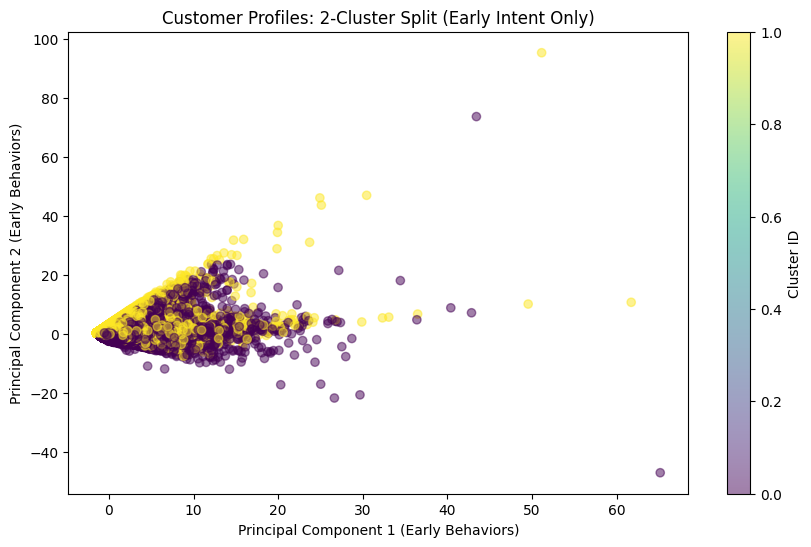

--- Average Stage Interactions per Cluster ---
stage    Apply for Credit  Credit Account  Discover  Downpayment  \
cluster                                                            
0                    5.48            0.24      1.03         0.45   
1                    5.93            0.26      0.00         0.47   

stage    First Purchase  Order Shipped  Unknown  
cluster                                          
0                 21.19           0.19     6.40  
1                 20.81           0.20     5.68  


--- Historical Success Rates by Cluster ---
Cluster 0: 0.2420 success rate (859157 users)
Cluster 1: 0.2688 success rate (595690 users)


In [40]:
# --- CLUSTERING AND STAGE MAPPING ---
# 1. Load the provided key mapping into a DataFrame
key_csv_data = """event_name,journey_id,event_definition_id,milestone_number,stage
application_phone_approved,1,15,1,Apply for Credit
application_phone_declined,1,16,,Apply for Credit
application_phone_pending,1,17,,Apply for Credit
application_web_approved,1,12,1,Apply for Credit
application_web_declined,1,13,,Apply for Credit
application_web_pending,1,14,,Apply for Credit
application_web_submit,1,3,,Apply for Credit
application_web_view,1,19,,Apply for Credit
account_activitation,1,29,3,Credit Account
account_fraud_review,1,37,,Credit Account
campaign_click,1,2,,Discover
customer_requested_catalog_digital,1,9,,Discover
fingerhut_university,1,10,,Discover
pre_application_3rd_party_affiliates,1,22,,Discover
site_registration,1,23,,Discover
account_downpaymentcleared,1,27,5,Downpayment
account_downpaymentreceived,1,26,,Downpayment
place_downpayment,1,8,4,Downpayment
place_downpayment_phone,1,25,4,Downpayment
add_to_cart,1,11,,First Purchase
begin_checkout,1,6,,First Purchase
browse_products,1,4,,First Purchase
place_order_phone,1,18,2,First Purchase
place_order_web,1,7,2,First Purchase
view_cart,1,5,,First Purchase
order_shipped,1,28,6,Order Shipped
catalog_email_experian,1,20,,Prospecting
catalog_mail,1,21,,Prospecting"""

df_key = pd.read_csv(io.StringIO(key_csv_data))

# 2. Merge the stages onto your clean tracking data
# df_clean is the dataframe after removing duplicates in Task 2
df_merged = df_clean.merge(df_key[['event_name', 'stage']], on='event_name', how='left')
df_merged['stage'] = df_merged['stage'].fillna('Unknown') 

# 3. Create a feature matrix: count of interactions per stage for each customer
customer_profiles = pd.crosstab(df_merged['id'], df_merged['stage'])

# THE 'EARLY INTENT' FILTER
# We explicitly drop the "leaky" bottom-of-funnel features
leaky_stages = ['Order Shipped', 'Downpayment', 'Credit Account']
early_intent_profiles = customer_profiles.drop(columns=[col for col in leaky_stages if col in customer_profiles.columns])

# 4. Scale the filtered features so stages with high volume do not dominate the distance metrics
scaler = StandardScaler()
scaled_features = scaler.fit_transform(early_intent_profiles)

# 5. Apply Basic K-Means Clustering into exactly 2 groups based ONLY on early intent
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
raw_clusters = kmeans.fit_predict(scaled_features)

# Attach clusters back to the ORIGINAL profiles so we can see what the "early intent" predicts
customer_profiles['cluster'] = raw_clusters

# 6. Reduce dimensions to 2D using PCA for visualization purposes
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# 7. Plot the raw clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=raw_clusters, cmap='viridis', alpha=0.5)
plt.title('Customer Profiles: 2-Cluster Split (Early Intent Only)')
plt.xlabel('Principal Component 1 (Early Behaviors)')
plt.ylabel('Principal Component 2 (Early Behaviors)')
plt.colorbar(label='Cluster ID')
plt.show() 

# 8. Output the average stage interactions per cluster
# We use the original customer_profiles here so we can see if our 'Early Intent' clusters 
# naturally captured the people who eventually made Downpayments
cluster_summary = customer_profiles.groupby('cluster').mean()
print("--- Average Stage Interactions per Cluster ---")
print(cluster_summary.round(2))
print("\n")

# --- STEP 3: ANALYZE SUCCESS RATES ---
# Temporarily merge the cluster assignments with the success labels to see their predictive power
df_analysis = customer_profiles[['cluster']].reset_index().merge(labels, on='id')

print("--- Historical Success Rates by Cluster ---")
for cluster_id in range(2):
    cluster_data = df_analysis[df_analysis['cluster'] == cluster_id]
    if len(cluster_data) > 0:
        success_rate = cluster_data['label'].mean()
        volume = len(cluster_data)
        print(f"Cluster {cluster_id}: {success_rate:.4f} success rate ({volume} users)")